# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)


In [4]:
from operator import add
movieRating = data.map(lambda d : (d["movieId"], 1)).foldByKey(0, add).collect()

In [8]:
userRating = data.map(lambda d : (d["userId"], 1)).foldByKey(0, add).collect()

## Exercice 3.4

### Plot the number of ratings for each user.

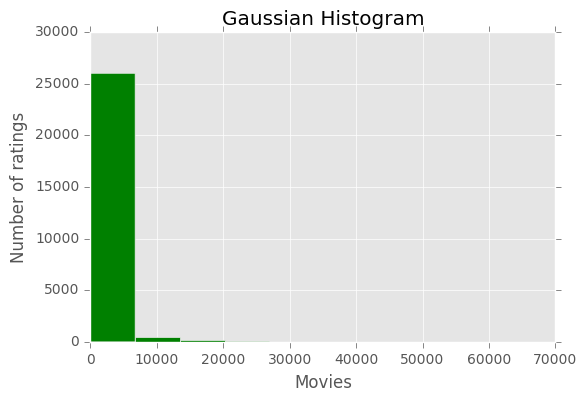

In [6]:
movieRating_val = [x[1] for x in movieRating]
plt.hist(movieRating_val, facecolor='green')
plt.title("Number of ratings for each user")
plt.xlabel("Movies")
plt.ylabel("Number of ratings")

### Plot the number of ratings for each item.

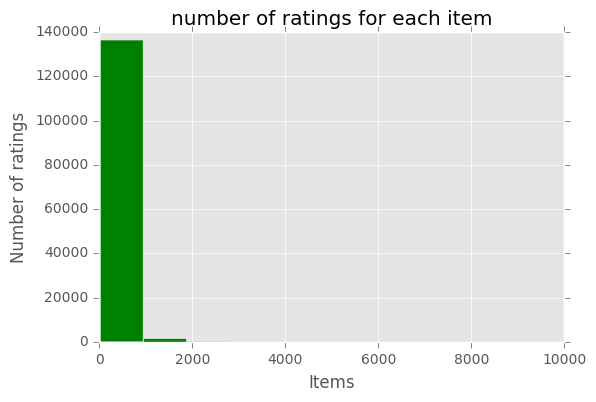

In [9]:
itemRating_val = [x[1] for x in userRating]
plt.hist(itemRating_val, facecolor='green')
plt.title("number of ratings for each item")
plt.xlabel("Items")
plt.ylabel("Number of ratings")

### Is the number of ratings balanced uniformly across users and movies?

Users have much more ratings than items. Thus items tend to be sparse.

## Exercice 3.5

### Append your personal ratings to the MovieLens dataset RDD

In [10]:
%run -i 'rate-movies.py'
user_id = 138494

Please rate the following movies.
1 (worst) -- 5 (best), or 0 if not seen

Toy Story (1995)
Adventure, Animation, Children, Comedy, Fantasy
your rating: 4

Independence Day (1996)
Action, Adventure, Sci-Fi, Thriller
your rating: 3

Dances with Wolves (1990)
Adventure, Drama, Western
your rating: 3

Star Wars: Episode VI - Return of the Jedi (1983)
Action, Adventure, Sci-Fi
your rating: 
input is invalid, try again.

Star Wars: Episode VI - Return of the Jedi (1983)
Action, Adventure, Sci-Fi
your rating: 3

Mission: Impossible (1996)
Action, Adventure, Mystery, Thriller
your rating: 4

Ace Ventura: Pet Detective (1994)
Comedy
your rating: 2

Die Hard: With a Vengeance (1995)
Action, Crime, Thriller
your rating: 2

Batman Forever (1995)
Action, Adventure, Comedy, Crime
your rating: 1

Pretty Woman (1990)
Comedy, Romance
your rating: 2

Men in Black (1997)
Action, Comedy, Sci-Fi
your rating: 4

Dumb & Dumber (1994)
Adventure, Comedy
your rating: 3

Successfully saved 11 ratings in `my-rat

### Partition the data into two sets: ~ 80% for training, and ~ 20% for validation

In [ ]:
# 20%
def validationSet(x): return (x["timestamp"]% 10) < 2

# 80%
def trainingSet(x): return not validationSet(x)

validationSetObject = data.filter(validationSet).collect()
trainingSetObject = data.filter(trainingSet).collect()

## Exercice 3.6

### Compute the global mean m, the user biases faug and the item biases fbmg using a sequence of RDD transformations on the training set.

In [ ]:
N = 20 # total number of rating

#global average rating mu
"""def mu(data):
    mu = 0;
    for u in range(users):
        rating_u = data.filter(lambda x : x["userId"]==u).collect();
        for m in range(movies):
            rating_u_m = rating_u.filter(lambda x : x["movieId"]==m).collect();
            r = rating_u_m if (len(rating_u_m) != 0) else 0;
            mu = mu + r
    mu = mu/N
    return mu
"""
def mu(data):
    return data.map(lambda x: x["rating"]).mean()


# user bias alpha_u
def alpha_u(u, mu):
    
    set_u = data.filter(lambda y : y["userId"] == u).map(lambda x : x["rating"]-mu).collect()
    alpha = set_u.mean()
    return alpha
    
    """
    for m in range(movies):
        r = rating[u,m] if (rating[u,m] != undefined) else 0;
        alpha_u = alpha_u + r - mu
    
    Nu = 10 # number of rating for user u
    alpha_u = alpha_u/Nu
    return alpha_u"""

# item bias beta_m
def beta_m(m, mu):
    
    set_m = data.filter(lambda y : y["movieId"] == m).map(lambda x : x["rating"]-mu).collect()
    beta = set_m.mean()
    return beta
    
    """
    beta_m = 0;
    
    for u in range(users):
        r = rating[u,m] if (rating[u,m] != undefined) else 0;
        beta_m = beta_m + r - alpha_u - mu

    Nm = 10 # number of rating for movie m
    beta_m = beta_m/Nm
    return beta_m
    """

mu(validationSetObject)

### How many parameters does this model have?

### Predict the rating of every user / movie pair in the validation set.

## Exercice 3.7

### Implement a function error() that takes an RDD containing (userId, movieId, rating) triplets and computes the error (3.2) with respect to the validation set. Use this function to evaluate the baseline predictions that you computed previously. You should obtain an error of approximately 0.922.

In [ ]:
#number of users
U = 100

def error():
    res = 0
    
    for u in range(users):
        tmp = 0
        Nu = 10 # number of rating for user u
        mu = mu()
        
        for m in range(movies):
            r_um = mu + alpha_u(u, mu) + beta_m(m, mu)
            tmp = tmp + (r_um - rating[u,m])**2
            
        res = res + np.sqrt(tmp/N_u)
            
    res = res/U
    return res

## Exercice 3.8

### What is the trade-off between choosing a lower and a higher rank?

Choosing a lower rank will lead to overgeneralizing, which won't be precize enough.
while choosing a higher rank might lead to overfitting, giving us something way more complex than wanted.

### How accurate are the predicted ratings? Can you explain the phenomenon?

In [40]:
lambda_ = 1e-4
print(lambda_)

pyspark.mllib.recommendation.ALS()

"""
learning a model with ALS()
2.  predicting ratings on the validation set using model.predictAll()
3.  evaluating the predictions using error()
"""

0.0001


### What happens to the predicted ratings, and why?

In [ ]:
lambda_ = 10

### Find the value of lambda_ that minimizes the validation error.

### What improvement do you get over the error of the baseline recommender system?

## Exercice 3.9

### Recommend 10 movies for user 123 using model.recommendProducts(). What kind of movies does the model think the user will like?

In [ ]:
model.recommendProducts()


### Recommend 10 movies to yourself (user ID: 138494). What do you think of your recommendations?

## Exercice 3.10

### Extract the features for all the movies in selected-movies.pickle.

### Create an interactive plot that embeds the movies along the 2 directions defined by the factorization

### Describe what you observe. Can you give a name to the dimensions? Do you recognize cluster of movies that are alike?